# Тема: Генерация текстового описания картинки
Задание: Трансформерный автоэнкодер для генерации текстовых описаний изображений: Реализация трансформерного автоэнкодера, способного автоматически генерировать текстовые описания на основе визуального содержимого изображений.


1. Загрузка изображений и аннотаций

In [5]:
from pycocotools.coco import COCO
from PIL import Image
import os
import matplotlib.pyplot as plt
import numpy as np

loading annotations into memory...
Done (t=0.26s)
creating index...
index created!
loading annotations into memory...
Done (t=0.12s)
creating index...
index created!

Captions:
1. A baseball player sliding into a base as the baseman tries to catch the ball
2. this is a man playing baseball and sliding
3. A baseball player sliding into the base while the opposing team member is attempting to catch the ball that put the player out.
4. A man sliding into second base while the second baseman tries to catch the ball.
5. A couple of guys playing baseballin the ball park.


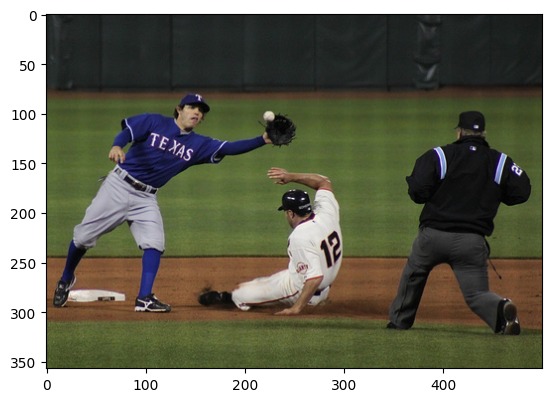

In [8]:
data_dir = '/Users/vitaliysayganov/Base/Study/DamnScience/DataSets/COCO'
train_annotation_file = os.path.join(data_dir, 'annotations', 'captions_train2014.json')
validation_annotation_file = os.path.join(data_dir, 'annotations', 'captions_val2014.json')

coco_train = COCO(train_annotation_file)
coco_val = COCO(validation_annotation_file)

# Загрузка изображений и текстовых аннотаций
def load_image(coco, img_id):
    img_info = coco.loadImgs(img_id)[0]
    img_path = os.path.join(data_dir, 'train2014', img_info['file_name'])
    image = Image.open(img_path)
    return image

def load_captions(coco, img_id):
    ann_ids = coco.getAnnIds(imgIds=img_id)
    captions = [coco.loadAnns(ann_id)[0]['caption'] for ann_id in ann_ids]
    return captions

# Пример: загрузка изображения и его описания
img_ids = coco_train.getImgIds()
img_id = img_ids[np.random.randint(0, len(img_ids))]  # используем первый id изображения для примера

image = load_image(coco_train, img_id)
captions = load_captions(coco_train, img_id)

# Выводим изображение и его описание
plt.imshow(image)
#image.show()
print("\nCaptions:")
for i, caption in enumerate(captions):
    print(i+1, ". ", caption, sep='')

In [9]:
import torch
from torchvision.transforms import v2 as transforms_v2
from torch.utils.data import Dataset, DataLoader
from collections import Counter
from nltk.tokenize import word_tokenize

In [10]:
imageTransformer = transforms_v2.Compose([
    transforms_v2.Resize(size=(224, 224), antialias=True),
    transforms_v2.ToTensor(),
    transforms_v2.RandomHorizontalFlip(p=0.5),
    transforms_v2.ToDtype(torch.float32, scale=True),
    transforms_v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

/Users/vitaliysayganov/Base/Study/DamnScience/profDS_belhard/.venv/lib/python3.9/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [14]:
# Пример: загрузка изображения и его описания
img_ids = coco_train.getImgIds()
img_id = img_ids[np.random.randint(0, len(img_ids))]  # используем первый id изображения для примера

image = load_image(coco_train, img_id)
captions = load_captions(coco_train, img_id)

img_array = np.array(image)
#print(np.array(image))
print(imageTransformer(img_array))


tensor([[[ 1.2385,  1.2385,  1.2385,  ..., -0.5424, -0.5767, -0.5082],
         [ 1.2214,  1.2043,  1.2214,  ..., -0.4226, -0.3712, -0.2513],
         [ 1.2385,  1.2214,  1.2385,  ..., -0.5767, -0.4911, -0.2684],
         ...,
         [ 0.2624,  0.4851,  0.4166,  ..., -1.7583, -1.7754, -0.9363],
         [ 0.3138,  0.1768,  0.2111,  ..., -1.8268, -1.7754, -0.8507],
         [ 0.1254,  0.2282,  0.3823,  ..., -1.8953, -1.7925, -0.9192]],

        [[ 1.3957,  1.3957,  1.3957,  ..., -0.7402, -0.7577, -0.7402],
         [ 1.3782,  1.3606,  1.3782,  ..., -0.6176, -0.5651, -0.4251],
         [ 1.3957,  1.3782,  1.3957,  ..., -0.7752, -0.6877, -0.4426],
         ...,
         [ 0.2927,  0.5203,  0.4503,  ..., -1.7906, -1.6856, -0.8803],
         [ 0.3277,  0.1877,  0.2227,  ..., -1.8606, -1.6856, -0.7927],
         [ 0.1352,  0.2402,  0.3978,  ..., -1.9307, -1.6856, -0.8627]],

        [[ 1.6117,  1.6117,  1.6117,  ..., -0.9330, -0.9853, -0.9504],
         [ 1.5942,  1.5768,  1.5942,  ..., -0

In [ ]:
# import nltk
# nltk.download('punkt_tab')

In [15]:
TOKENIZE_THRESHOLD = 5
PAD_TOKEN = '<pad>'
START_TOKEN = '<start>'
END_TOKEN = '<end>'
UNKNOWN_TOKEN = '<unk>'
PAD_TOKEN_IDX = 0
MAX_CAPTION_LENGTH = -1

def tokenize(annotation):
    return word_tokenize(annotation.lower())

def build_vocab(captions, threshold=TOKENIZE_THRESHOLD):
    global MAX_CAPTION_LENGTH
    counter = Counter()
    for caption in captions:
        tokens = tokenize(caption)
        counter.update(tokens)
        if len(caption) > MAX_CAPTION_LENGTH:
            MAX_CAPTION_LENGTH = len(caption)

    words = [word for word, count in counter.items() if count >= threshold]
    vocab = {word: idx+1 for idx, word in enumerate(words)}
    vocab[PAD_TOKEN] = PAD_TOKEN_IDX
    vocab[START_TOKEN] = len(vocab)
    vocab[END_TOKEN] = len(vocab)
    vocab[UNKNOWN_TOKEN] = len(vocab)
    return vocab

def caption_to_idx(caption, vocab):
    tokens = tokenize(caption)
    caption_idx = [vocab.get(START_TOKEN)] + [vocab.get(word, vocab[UNKNOWN_TOKEN]) for word in tokens] + [vocab.get(END_TOKEN)]
    return caption_idx

all_captions = [ann['caption'] for ann in coco_train.loadAnns(coco_train.getAnnIds())]
vocab = build_vocab(all_captions)

In [16]:
class CocoDataset(Dataset):
    def __init__(self, coco, vocab, transform=None):
        self.coco = coco
        self.vocab = vocab
        self.transform = transform
        self.img_ids = list(self.coco.imgs.keys())

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        anns = self.coco.loadAnns(ann_ids)
        caption = anns[0]['caption']  # выбираем первое описание для изображения
        caption_idx = caption_to_idx(caption, self.vocab)

        # Загрузка и преобразование изображения
        img_info = self.coco.loadImgs(img_id)[0]
        img_path = os.path.join(data_dir, 'train2014', img_info['file_name'])
        image = Image.open(img_path).convert('RGB')
        if self.transform is not None:
            image = self.transform(image)

        return image, torch.tensor(caption_idx)
    

def collate_fn(batch):
    images, captions = zip(*batch)
    images = torch.stack(images, 0)
    
    padded_captions = torch.zeros(len(captions), MAX_CAPTION_LENGTH, dtype=torch.long)
    
    for i, cap in enumerate(captions):
        padded_captions[i, :len(cap)] = cap
    
    return images, padded_captions

# Создаем экземпляр датасета и загрузчика данных
dataset = CocoDataset(coco_train, vocab, transform=imageTransformer)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True, collate_fn=collate_fn)

Шаг 2: Создание энкодера

Мы используем предобученную сверточную нейронную сеть, такую как ResNet, для извлечения признаков изображения. В ResNet удалим последние слои классификации, чтобы получить выходные признаки.

In [17]:
import torch
import torch.nn as nn
import torchvision.models as models

class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        super(EncoderCNN, self).__init__()
        # Загружаем предобученную модель ResNet50
        resnet = models.resnet50(pretrained=True)
        
        # Удаляем последний слой классификации
        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)
        
        # Проекция в пространство нужного размера (embed_size)
        self.fc = nn.Linear(resnet.fc.in_features, embed_size)
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)

    def forward(self, images):
        # Извлечение признаков
        with torch.no_grad():  # отключаем градиенты для энкодера
            features = self.resnet(images).squeeze()
        features = self.fc(features)
        features = self.bn(features)
        return features

Шаг 3: Создание декодера на основе трансформера

Теперь мы создадим декодер на основе трансформера, который будет генерировать текстовые описания, используя механизм внимания к признакам, полученным от энкодера.

In [23]:
import math

class DecoderTransformer(nn.Module):
    def __init__(self, embed_size, vocab_size, num_heads, num_layers, max_seq_length, dropout=0.1):
        super(DecoderTransformer, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.positional_encoding = nn.Parameter(torch.zeros(1, max_seq_length, embed_size))
        
        # Трансформерный декодер
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=embed_size,
            nhead=num_heads,
            dropout=dropout
        )
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)
        
        # Полносвязный слой для предсказания слов
        self.fc = nn.Linear(embed_size, vocab_size)

    def forward(self, features, captions):
        # Применяем эмбеддинг и добавляем позиционное кодирование
        captions = self.embed(captions) + self.positional_encoding[:, :captions.size(1), :]
        
        features = features.unsqueeze(1).repeat(1, captions.size(1), 1)

        # Трансформерный декодер
        tgt_mask = self.generate_square_subsequent_mask(captions.size(1)).to(captions.device)
        output = self.transformer_decoder(captions.permute(1, 0, 2), features.permute(1, 0, 2), tgt_mask=tgt_mask)
        
        # Прогноз слов
        output = self.fc(output.permute(1, 0, 2))
        return output

    def generate_square_subsequent_mask(self, size):
        mask = (torch.triu(torch.ones(size, size)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

Шаг 4: Объединение энкодера и декодера в одну модель

Теперь мы можем объединить энкодер и декодер в одну модель, чтобы передавать признаки изображения из энкодера на вход декодеру и получать текстовое описание.

In [24]:
class ImageCaptioningModel(nn.Module):
    def __init__(self, embed_size, vocab_size, num_heads, num_layers, max_seq_length):
        super(ImageCaptioningModel, self).__init__()
        self.encoder = EncoderCNN(embed_size)
        self.decoder = DecoderTransformer(embed_size, vocab_size, num_heads, num_layers, max_seq_length)

    def forward(self, images, captions):
        features = self.encoder(images)
        outputs = self.decoder(features, captions)
        return outputs

Шаг 5: Настройка процесса обучения

Мы создадим функцию потерь и оптимизатор для обучения модели. Для задачи генерации текста обычно используют CrossEntropyLoss.

In [25]:
import torch.optim as optim

# Параметры модели
embed_size = 256
vocab_size = len(vocab)
num_heads = 8
num_layers = 6
max_seq_length = MAX_CAPTION_LENGTH

# Инициализация модели
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ImageCaptioningModel(embed_size, vocab_size, num_heads, num_layers, max_seq_length).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=vocab["<pad>"])
optimizer = optim.Adam(model.parameters(), lr=0.001)

/Users/vitaliysayganov/Base/Study/DamnScience/profDS_belhard/.venv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/vitaliysayganov/Base/Study/DamnScience/profDS_belhard/.venv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [22]:
MAX_CAPTION_LENGTH

250

Шаг 6: Обучение модели

Теперь можно приступить к обучению модели. На каждой итерации мы будем передавать изображения и соответствующие описания в модель, вычислять потери и обновлять веса.

In [26]:
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    
    for images, captions in dataloader:
        images, captions = images.to(device), captions.to(device)
        
        # Обнуление градиентов
        optimizer.zero_grad()
        
        # Прямой проход и расчет потерь
        outputs = model(images, captions[:, :-1])  # исключаем последний токен из caption для teacher forcing
        loss = criterion(outputs.reshape(-1, vocab_size), captions[:, 1:].reshape(-1))
        
        # Обратный проход и обновление весов
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(dataloader):.4f}")

KeyboardInterrupt: 

In [62]:
vocab.values()

dict_values([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 